In [5]:
import yfinance
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
# y data profiling import
from ydata_profiling import ProfileReport
# import one hot encoder
from sklearn.preprocessing import OneHotEncoder
import tsfresh
# min max scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#import train test split
from sklearn.model_selection import train_test_split
from feature_engine.imputation import AddMissingIndicator
from sklearn.neighbors import LocalOutlierFactor
from matplotlib.legend_handler import HandlerPathCollection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# import svc
from sklearn.svm import SVC
# import knn
from sklearn.neighbors import KNeighborsClassifier
# import gridsearch
from sklearn.model_selection import GridSearchCV
# import sklearn.neural_network 
from sklearn.neural_network import MLPClassifier
from feature_engine.outliers import Winsorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# import joblib
import joblib



In [7]:
class DefineFunctions:
    def __init__(self):
        pass
        

    def fetch_sector_names(self):
        url = "https://stockanalysis.com/stocks/industry/sectors/"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            df= pd.read_html(str(soup.find_all("table")))[0]
        else:
            print("Error fetching data from stockanalysis.com")
        return df

    def fetch_data(self,sectors):
        url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            df= pd.read_html(str(soup.find_all("table")))[0]
            df.drop(columns='No.', inplace=True)
        else:
            print("Error fetching data from stockanalysis.com")
        return df

    def download_sectors_stock(self):
        sectors = self.fetch_sector_names().iloc[:,0].to_list()
        formatted_sectors_names = [sector.lower().replace(' ', '-') for sector in sectors]
        print(formatted_sectors_names)
        for sector in formatted_sectors_names:
            file_path = f"./stock_sectors/{sector}.csv"
            if not os.path.exists(file_path):
                data = self.fetch_data(sectors=sector)
                directory = "./stock_sectors"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                data.to_csv(f"{directory}/{sector}.csv", index=False)
                return data
            else:
                print(f"{sector}.csv already exists. Skipping download.")

    def sector_data_close(self,stock_path):
        csv_path = stock_path.split("/")[2]
        if os.path.exists(f"./data_close/{csv_path}"):
            print(f"{csv_path} dosyası zaten mevcut. İşlem atlandı.")
            data_frame = pd.read_csv(f"./data_close/{csv_path}")
            # indexi date sütunu olarak ata
            data_frame.set_index('Date', inplace=True)
            return data_frame
        sector = pd.read_csv(stock_path)
        ticker_list = sector[sector['Symbol'].apply(lambda x: isinstance(x, str))]['Symbol'].tolist()
        # ilk 5 hisse senedi 
        # ticker_list = sector['Symbol'].head(5).tolist()
        data = yfinance.download(ticker_list,start='2005-01-01')
        data_close = data['Adj Close'].resample("W-MON").last().pct_change()+1
        data_close.to_csv(f"./data_close/{csv_path}")

        return data_close
    
    def y_data_profiling(self,data_frame):
        profile = ProfileReport(data_frame, title="Pandas Profiling Report")
        profile.to_file(f"data_profiling_{data_frame}.html")

    def fill_na_before_melted(self,data_frame):
        data_frame = data_frame.dropna(axis=1, how='all')
        data_frame = data_frame.fillna(method='bfill')
        return data_frame
    
    def is_na_sum(self,data_frame):
        return data_frame.isna().sum().sum()
    
    def moving_avarage(self,data,n):
        return data.rolling(window=n).mean()
    
    def get_rolling_ret(data, n): 
        return data.rolling(n).apply(np.prod)

    def add_sectors_column(self,data_finance, data_healthcare, data_tech):
        data_finance['sector'] = 'F'
        data_healthcare['sector'] = 'H'
        data_tech['sector'] = 'T'
        
        data_finance.to_csv("./added_sector/financials.csv", index=True)
        data_healthcare.to_csv("./added_sector/healthcare.csv", index=True)
        data_tech.to_csv("./added_sector/technology.csv", index=True)
        return data_finance, data_healthcare, data_tech
        


    def melted_data(self,data_frame):
        melted_data = data_frame.melt(var_name='symbol', value_name='close',id_vars = 'Date')
        return melted_data


    def data_profiling(self,data_frame):
        profile = ProfileReport(data_frame, title="Pandas Profiling Report")
        profile.to_file("data_profiling.html")

    def merged_data_function(self,data_frame_finance, data_frame_healthcare, data_frame_tech):
        merged_data = pd.concat([data_frame_finance, data_frame_healthcare, data_frame_tech], axis=0)
        return merged_data


    def tsfresh_features(self,data_frame):
        # Özellikleri çıkarın
        df_features = tsfresh.extract_features(data_frame, column_id='symbol', column_sort='Date',
                                        default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
        return df_features

    def scaling(self,data_frame):
    #sector sütunu hariç scale uygula dataframe olarak döndür
        scaler = StandardScaler()
        data_frame_scaled = data_frame.copy()
        data_frame_scaled.loc[:, data_frame_scaled.columns != 'sector'] = scaler.fit_transform(data_frame_scaled.loc[:, data_frame_scaled.columns != 'sector'])
        data_frame_scaled['sector'] = data_frame['sector']
        return data_frame_scaled
        

    def after_tsfresh_fillna(self,data_frame):
        # Sonsuz değerleri aralığa çek
        data_frame = data_frame.replace([np.inf, -np.inf], np.nan)
        
        # 'sector' sütununu çıkarılmış DataFrame'i oluştur  
        # knn ile doldur
        # imputer = KNNImputer(n_neighbors=5)
        # data_frame_2 = pd.DataFrame(imputer.fit_transform(data_frame_2), columns=data_frame_2.columns,index=data_frame.index)
        # data_frame_2['sector'] = data_frame['sector']

        # return data_frame_2
        # Add Mising İndicator uygula
        # indicator = AddMissingIndicator()
        # data_frame = indicator.fit_transform(data_frame)
        # median ile doldur sayısal değerleri
        number_variables = data_frame.select_dtypes(include=[np.float64, np.int64]).columns
        imputer = SimpleImputer(strategy='median')
        imputer.fit(data_frame[number_variables])
        data_frame[number_variables] = imputer.transform(data_frame[number_variables])
        return data_frame
        # from sklearn.experimental import enable_iterative_imputer
        # from sklearn.impute import IterativeImputer

        # from sklearn.linear_model import BayesianRidge
        # imputer = IterativeImputer(estimator=BayesianRidge(), initial_strategy='mean', random_state=0)

        # degiskenler = data_frame.select_dtypes(include=[np.float64, np.int64]).columns

        # data_frame[degiskenler] = imputer.fit(data_frame[degiskenler])
        
        # return data_frame
        



    


In [35]:
class ApplyFuncionsOnData(DefineFunctions):
    def __init__(self):
       self.download_data()
       
    

    def download_data(self):
        self.tech_data = super().sector_data_close("./stock_sectors/technology.csv")
        self.finance_data = super().sector_data_close("./stock_sectors/financials.csv")
        self.health_data = super().sector_data_close("./stock_sectors/healthcare.csv")

    def apply_data_profiling(self):
        super().y_data_profiling(self.tech_data)
        super().y_data_profiling(self.finance_data)
        super().y_data_profiling(self.health_data)

    def before_ts_fillna(self):
        self.tech_data = super().fill_na_before_melted(self.tech_data)
        self.finance_data = super().fill_na_before_melted(self.finance_data)
        self.health_data = super().fill_na_before_melted(self.health_data)
        print("is_na_sum:",self.is_na_sum(self.tech_data))
        print("is_na_sum:",self.is_na_sum(self.finance_data))
        print("is_na_sum:",self.is_na_sum(self.health_data))
    
    
    
    def apply_ma(self):
       
        self.tech_data = super().moving_avarage(self.tech_data, 4)
        self.finance_data = super().moving_avarage(self.finance_data, 4)
        self.health_data = super().moving_avarage(self.health_data, 4)
        self.tech_data = self.fill_na_before_melted(self.tech_data)
        self.finance_data = self.fill_na_before_melted(self.finance_data)
        self.health_data = self.fill_na_before_melted(self.health_data)
        print("is_na_sum:",self.is_na_sum(self.tech_data))
        print("is_na_sum:",self.is_na_sum(self.finance_data))
        print("is_na_sum:",self.is_na_sum(self.health_data))
     
        

    def reset_index(self):
        self.tech_data.reset_index(inplace=True)
        self.finance_data.reset_index(inplace=True)
        self.health_data.reset_index(inplace=True)
        
    
  
    
    def melted_data_apply(self):
        self.finance_data = super().melted_data(self.finance_data)
        self.tech_data = super().melted_data(self.tech_data)
        self.health_data = super().melted_data(self.health_data)
    
    def create_tsfresh_features(self):
        self.finance_data_ts = super().tsfresh_features(self.finance_data)
        self.tech_data_ts = super().tsfresh_features(self.tech_data)
        self.health_data_ts = super().tsfresh_features(self.health_data)

        self.finance_data_ts.to_csv("./features/finance_features.csv")
        self.tech_data_ts.to_csv("./features/tech_features.csv")
        self.health_data_ts.to_csv("./features/health_features.csv")
    
    def add_sector_columns(self):
        # ilk sütunu index olarak ata ve kaldır 

        self.finance_data_ts = pd.read_csv("./features/finance_features.csv",index_col=0)
        self.tech_data_ts = pd.read_csv("./features/tech_features.csv",index_col=0)
        self.health_data_ts = pd.read_csv("./features/health_features.csv",index_col=0)
        super().add_sectors_column(self.finance_data_ts, self.health_data_ts, self.tech_data_ts)
    
    def merged_columns(self):
        self.merged_data = super().merged_data_function(self.finance_data_ts, self.health_data_ts, self.tech_data_ts)
        self.merged_data.dropna(axis=1, how='all', inplace=True)
        self.not_na_merged_data = super().after_tsfresh_fillna(self.merged_data)
    
    def scaling_data(self):
        
        # # drop categorical column
        # numerical_value = self.not_na_merged_data.drop(columns=self.not_na_merged_data.columns[(self.not_na_merged_data.isin([0,1]).all())])
        # self.scaled_data = super().scaling(numerical_value)
        # # çıkarılan değerleri tekrar ekle 
        # self.scaled_data = pd.concat([self.scaled_data, self.not_na_merged_data[self.not_na_merged_data.columns[(self.not_na_merged_data.isin([0,1]).all())]]], axis=1)
        self.scaled_data = super().scaling(self.not_na_merged_data)
       
    def outlier_fix(self):
        Q1 = self.scaled_data.drop(columns='sector').quantile(0.25)
        Q3 = self.scaled_data.drop(columns='sector').quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        for column in self.scaled_data.columns:
             if self.scaled_data[column].dtype in ['float64','int64']:
                self.scaled_data[column] = self.scaled_data[column].apply(lambda x: lower_bound[column] if x < lower_bound[column] else x)
                self.scaled_data[column] = self.scaled_data[column].apply(lambda x: upper_bound[column] if x > upper_bound[column] else x)
        return self.scaled_data

    def data_train_split(self):
        self.X = self.scaled_data.drop(columns='sector')
        # y değerlerini F = 0, H = 1, T = 2 olarak encode et
        self.y = self.scaled_data['sector'].map({'F': 0, 'H': 1, 'T': 2})
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=22)        
        
    
        

    def apply_pca(self):
        from sklearn.decomposition import PCA
        pca = PCA(n_components=180, random_state=42, whiten=True, svd_solver='full')
        self.X_pca_train = pca.fit_transform(self.X)
        self.X_pca_test = pca.transform(self.X_test)
        self.explained_variance_ratio = pca.explained_variance_ratio_

        # cumulative variance ratio
        explained_variance = pca.explained_variance_
        self.total_explained_variance = explained_variance.sum()

        
    
    def cumulative_plot(self):
        plt.figure(figsize=(10, 7))
        plt.plot(np.cumsum(self.explained_variance_ratio))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.show()
  
    # def grid_search(self, model=KNeighborsClassifier()):
    #     if isinstance(model, KNeighborsClassifier):
    #         param_grid = {
    #             'n_neighbors': [3, 5, 7, 9],
    #             'metric': ['euclidean', 'manhattan'],
    #             'weights': ['uniform', 'distance']
    #         }
    #     elif isinstance(model, SVC):
    #         param_grid = {
    #             'C': [0.1, 1, 10, 100],
    #             'kernel': ['linear', 'rbf', 'poly'],
    #             'gamma': ['scale', 'auto']
    #         }
    #     elif isinstance(model, RandomForestClassifier):
    #         param_grid = {
    #             'n_estimators': [100, 200, 300, 400],
    #             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #             'min_samples_split': [2, 5, 10],
    #             'min_samples_leaf': [1, 2, 4],
    #             'bootstrap': [True, False]
    #         }
            
    #     elif isinstance(model, LogisticRegression):
    #         param_grid = {
    #             'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    #             'C': [0.1, 1, 10, 100],
    #             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    #         }
    #     elif isinstance(model, XGBClassifier):
    #         param_grid = {
    #             'n_estimators': [100, 200, 300, 400],
    #             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #             'learning_rate': [0.05, 0.1, 0.15, 0.2],
    #             'min_child_weight': [1, 2, 3, 4]
    #         }
    #     else:
    #         print("Model is not found")
    #     self.grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
    #     self.grid_search.fit(self.X_pca_train, self.y_train)
    #     return self.grid_search.best_estimator_
    


    def create_and_fit_model(self, model=LogisticRegression(max_iter=1000, random_state=16, n_jobs=-1)):
        self.model = model
        self.model.fit(self.X_pca_train, self.y)
        joblib.dump(self.model, 'model.pkl')
        
    
    def evulate_model(self,test_data):
        self.y_pred = self.model.predict(test_data)
        # y_pred = result.predict(self.X_pca_test)
        # confusion matrix
        
        self.cm = confusion_matrix(self.y_test, self.y_pred)

        # accuracy score
        
        acc = accuracy_score(self.y_test, self.y_pred)

        # precision score
        
        precision_s = precision_score(self.y_test, self.y_pred, average='weighted')

        # recall score
        
        recall_s = recall_score(self.y_test, self.y_pred, average='weighted')
        # f1 score
        f1 = f1_score(self.y_test, self.y_pred, average='weighted')
        # classification report

        print(classification_report(self.y_test, self.y_pred))

        print(f"acc : {acc}, precision : {precision_s}, recall : {recall_s}, confusion_matrix : {self.cm}, f1_score : {f1}")

    def plot_confusion_matrix(self):
        
        sns.heatmap(self.cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()
    
    def comparison_y_pred(self):
        comparison = pd.DataFrame({'y_test': self.y_test, 'y_pred': self.y_pred})
        
        # eğer self.y_test 0 ise F 1 ise H 2 ise T olarak real value sütunu ekle her satıra
        # eğer self.y_pred 0 ise F 1 ise H 2 ise T olarak tahmin edilen value sütunu ekle her satıra
        comparison['real_value'] = comparison['y_test'].map({0: 'F', 1: 'H', 2: 'T'})
        comparison['predicted_value'] = comparison['y_pred'].map({0: 'F', 1: 'H', 2: 'T'})
        return comparison
    
    
        


        

In [36]:
class ApplyTestDataFunc(DefineFunctions):
    def __init__(self,stock_path):
        self.download_data(stock_path)
    
    def sector_data_close_1(self,stock_path):
        csv_path = stock_path.split("/")[2]
        if os.path.exists(f"./data_close_test/{csv_path}"):
            print(f"{csv_path} dosyası zaten mevcut. İşlem atlandı.")
            data_frame = pd.read_csv(f"./data_close_test/{csv_path}")
            # indexi date sütunu olarak ata
            data_frame.set_index('Date', inplace=True)
            return data_frame
        sector = pd.read_csv(stock_path)
        # ticker_list = sector[sector['Symbol'].apply(lambda x: isinstance(x, str))]['Symbol'].tolist()
        # ilk 5 hisse senedi 
        ticker_list = sector['Symbol'].head(300).tolist()
        data = yfinance.download(ticker_list,start='2005-01-01')
        data_close = data['Adj Close'].resample("W-MON").last().pct_change()+1
        data_close.to_csv(f"./data_close_test/{csv_path}")
    
    def download_data(self,stock_path):
        self.test_data = super().sector_data_close(stock_path)
        
    def before_ts_fillna(self):
        self.test_data = super().fill_na_before_melted(self.test_data)
        print("is_na_sum:",self.is_na_sum(self.test_data))
    
    def apply_ma(self):
       
        self.test_data = super().moving_avarage(self.test_data, 4)
        self.test_data = self.fill_na_before_melted(self.test_data)
    
    def reset_index(self):
        self.test_data.reset_index(inplace=True)
    
    def melted_data_apply(self):
        self.test_data = super().melted_data(self.test_data)
        
    
    def create_tsfresh_features(self):
        self.test_data_ts = super().tsfresh_features(self.test_data)

        self.test_data_ts.to_csv("./test_features/finance_features.csv")
    
    def after_ts_fillna(self):
        self.test_data_features = pd.read_csv("./test_features/finance_features.csv",index_col=0)
        self.test_data_features.dropna(axis=1, how='all', inplace=True)
        self.test_data_features = super().after_tsfresh_fillna(self.test_data_features)
    
    def scaling_test_data(self):
       scaler = StandardScaler()
       self.scaled_test_data = scaler.fit_transform(self.test_data_features)
       # dataframe çevir
       self.scaled_test_data = pd.DataFrame(self.scaled_test_data, columns=self.test_data_features.columns, index=self.test_data_features.index)  

    def outlier_fix_test(self):
        Q1 = self.scaled_test_data.quantile(0.25)
        Q3 = self.scaled_test_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        for column in self.scaled_test_data.columns:
             if self.scaled_test_data[column].dtype in ['float64','int64']:
                self.scaled_test_data[column] = self.scaled_test_data[column].apply(lambda x: lower_bound[column] if x < lower_bound[column] else x)
                self.scaled_test_data[column] = self.scaled_test_data[column].apply(lambda x: upper_bound[column] if x > upper_bound[column] else x)
        return self.scaled_test_data  

    def apply_pca_test(self):
        from sklearn.decomposition import PCA
        pca = PCA(n_components=180)
        self.X_pca_test = pca.fit_transform(self.scaled_test_data)
        
        self.explained_variance_ratio = pca.explained_variance_ratio_

        # cumulative variance ratio
        explained_variance = pca.explained_variance_
        self.total_explained_variance = explained_variance.sum()   


    def prediction_test_data(self):
        self.model = joblib.load('model.pkl')
        self.y_pred = self.model.predict(self.X_pca_test)
        
        self.comparison = pd.DataFrame({'y_pred': self.y_pred}, index=self.test_data_features.index)
        self.comparison['predicted_value'] = self.comparison['y_pred'].map({0: 'F', 1: 'H', 2: 'T'})
           
        

technology.csv dosyası zaten mevcut. İşlem atlandı.
financials.csv dosyası zaten mevcut. İşlem atlandı.
healthcare.csv dosyası zaten mevcut. İşlem atlandı.


C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')


is_na_sum: 0
is_na_sum: 0
is_na_sum: 0


C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')


is_na_sum: 0
is_na_sum: 0
is_na_sum: 0
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       191
           1       0.76      0.79      0.77       243
           2       0.70      0.69      0.70       167

    accuracy                           0.78       601
   macro avg       0.78      0.77      0.78       601
weighted avg       0.78      0.78      0.78       601

acc : 0.778702163061564, precision : 0.779882915199055, recall : 0.778702163061564, confusion_matrix : [[161  21   9]
 [ 12 191  40]
 [ 11  40 116]], f1_score : 0.779087190085406


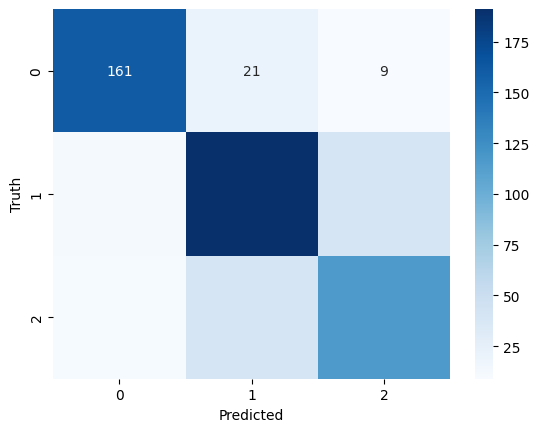

In [38]:
class_1 = ApplyFuncionsOnData()
# sklearn pipeline kullan
pipeline = Pipeline([
    # ('y_data_profiling', class_1.apply_data_profiling()),
    ('tsfresh_before_fill', class_1.before_ts_fillna()),
    ('apply_moving_avarage',class_1.apply_ma()),
    ('reset_index', class_1.reset_index()),
    ('melted_data',class_1.melted_data_apply()),
    ('create_tsfresh_features',class_1.create_tsfresh_features()),
    ('add_sector_columns',class_1.add_sector_columns()),
    ('merged_columns',class_1.merged_columns()),
    ('scaling_data',class_1.scaling_data()),
    ('outlier_fix',class_1.outlier_fix()),
    ('data_train_split',class_1.data_train_split()),
    ('apply_pca',class_1.apply_pca()),
    ('create_and_fit_model',class_1.create_and_fit_model()),
    # ('grid_search',class_1.grid_search(model=RandomForestClassifier())),
    ('evulate_model',class_1.evulate_model(test_data=class_1.X_pca_test)),
    ('plot_confusion_matrix',class_1.plot_confusion_matrix())
])

In [6]:
class_1.finance_data.head()

,Date,symbol,close
0,2005-01-03,AACI,1.001021
1,2005-01-10,AACI,1.001021
2,2005-01-17,AACI,1.001021
3,2005-01-24,AACI,1.001021
4,2005-01-31,AACI,1.001021


In [39]:
class_test_economy = ApplyTestDataFunc(stock_path="./stock_sectors/energy.csv")
pipeline_test_economy = Pipeline([
    ('tsfresh_before_fill', class_test_economy.before_ts_fillna()),
    ('apply_ma', class_test_economy.apply_ma()),
    ('reset_index', class_test_economy.reset_index()),
    ('melted_data', class_test_economy.melted_data_apply()),
    ('create_tsfresh_features', class_test_economy.create_tsfresh_features()),
    ('after_ts_fillna', class_test_economy.after_ts_fillna()),
    ('scaling_test_data', class_test_economy.scaling_test_data()),
    ('outlier_fix_test', class_test_economy.outlier_fix_test()),
    ('apply_pca_test', class_test_economy.apply_pca_test()),
    ('prediction_test_data', class_test_economy.prediction_test_data())
    
    
    
])

energy.csv dosyası zaten mevcut. İşlem atlandı.
is_na_sum: 0


C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')


In [40]:
class_test_materials = ApplyTestDataFunc(stock_path="./stock_sectors/materials.csv")
pipeline_test_materials = Pipeline([
    ('tsfresh_before_fill', class_test_materials.before_ts_fillna()),
    ('apply_ma', class_test_materials.apply_ma()),
    ('reset_index', class_test_materials.reset_index()),
    ('melted_data', class_test_materials.melted_data_apply()),
    ('create_tsfresh_features', class_test_materials.create_tsfresh_features()),
    ('after_ts_fillna', class_test_materials.after_ts_fillna()),
    ('scaling_test_data', class_test_materials.scaling_test_data()),
    ('outlier_fix_test', class_test_materials.outlier_fix_test()),
    ('apply_pca_test', class_test_materials.apply_pca_test()),
    ('prediction_test_data', class_test_materials.prediction_test_data())
    ])


materials.csv dosyası zaten mevcut. İşlem atlandı.
is_na_sum: 0


C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')


In [41]:
class_test_industrials = ApplyTestDataFunc(stock_path="./stock_sectors/industrials.csv")
pipeline_test_industrials = Pipeline([
    ('tsfresh_before_fill', class_test_industrials.before_ts_fillna()),
    ('apply_ma', class_test_industrials.apply_ma()),
    ('reset_index', class_test_industrials.reset_index()),
    ('melted_data', class_test_industrials.melted_data_apply()),
    ('create_tsfresh_features', class_test_industrials.create_tsfresh_features()),
    ('after_ts_fillna', class_test_industrials.after_ts_fillna()),
    ('scaling_test_data', class_test_industrials.scaling_test_data()),
    ('outlier_fix_test', class_test_industrials.outlier_fix_test()),
    ('apply_pca_test', class_test_industrials.apply_pca_test()),
    ('prediction_test_data', class_test_industrials.prediction_test_data())
    ])


industrials.csv dosyası zaten mevcut. İşlem atlandı.
is_na_sum: 0


C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')
C:\Users\90507\AppData\Local\Temp\ipykernel_16844\1194288661.py:67: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill')


In [14]:
class_1.tech_data.head(3)
class_1.finance_data.head(3)
class_1.health_data.head(3)

,Date,symbol,close
0,2005-01-03,AAOI,1.018
1,2005-01-10,AAOI,1.018
2,2005-01-17,AAOI,1.018


,Date,symbol,close
0,2005-01-03,AACI,1.001021
1,2005-01-10,AACI,1.001021
2,2005-01-17,AACI,1.001021


,Date,symbol,close
0,2005-01-03,A,0.960199
1,2005-01-10,A,0.960199
2,2005-01-17,A,0.960199


In [15]:
class_1.tech_data.isna().mean()
class_1.finance_data.isna().mean()
class_1.health_data.isna().mean()

Date      0.0
symbol    0.0
close     0.0
dtype: float64

Date      0.0
symbol    0.0
close     0.0
dtype: float64

Date      0.0
symbol    0.0
close     0.0
dtype: float64

In [16]:
class_1.finance_data_ts.head(3)

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__query_similarity_count__query_None__threshold_0.0,close__mean_n_absolute_max__number_of_maxima_7,sector
AACI,0.0,0.0,0.0,1.0,1004.041013,1005.084113,0.000184,0.000021,1.026312e-05,1.001021,...,0.090729,0.090729,0.447287,0.680720,0.850841,0.930351,0.946109,NaN,1.008370,F
AACT,0.0,1.0,0.0,1.0,1005.907235,1008.823026,0.000014,-0.000002,-6.022700e-08,1.002967,...,NaN,NaN,0.211598,0.270215,0.293950,0.300286,0.300549,NaN,1.002967,F
AAMC,0.0,0.0,0.0,1.0,954.164640,909.013894,0.004042,0.000052,1.678932e-05,0.944762,...,0.090729,0.090729,0.399986,0.570750,0.700725,0.771504,0.800508,NaN,1.200738,F


In [17]:
class_1.not_na_merged_data.head(3)

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__mean_n_absolute_max__number_of_maxima_7,sector
AACI,0.0,0.0,0.0,1.0,1004.041013,1005.084113,0.000184,0.000021,1.026312e-05,1.001021,...,0.090729,0.090729,0.090729,0.447287,0.680720,0.850841,0.930351,0.946109,1.008370,F
AACT,0.0,1.0,0.0,1.0,1005.907235,1008.823026,0.000014,-0.000002,-6.022700e-08,1.002967,...,0.570143,0.946241,2.529204,0.211598,0.270215,0.293950,0.300286,0.300549,1.002967,F
AAMC,0.0,0.0,0.0,1.0,954.164640,909.013894,0.004042,0.000052,1.678932e-05,0.944762,...,0.090729,0.090729,0.090729,0.399986,0.570750,0.700725,0.771504,0.800508,1.200738,F


In [18]:
class_1.merged_data.head()


,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1,close__mean_n_absolute_max__number_of_maxima_7,sector
AACI,0.0,0.0,0.0,1.0,1004.041013,1005.084113,0.000184,0.000021,1.026312e-05,1.001021,...,0.090729,0.090729,0.090729,0.447287,0.680720,0.850841,0.930351,0.946109,1.008370,F
AACT,0.0,1.0,0.0,1.0,1005.907235,1008.823026,0.000014,-0.000002,-6.022700e-08,1.002967,...,NaN,NaN,NaN,0.211598,0.270215,0.293950,0.300286,0.300549,1.002967,F
AAMC,0.0,0.0,0.0,1.0,954.164640,909.013894,0.004042,0.000052,1.678932e-05,0.944762,...,0.090729,0.090729,0.090729,0.399986,0.570750,0.700725,0.771504,0.800508,1.200738,F
AAME,0.0,0.0,0.0,1.0,1006.208991,1010.953395,0.017913,0.000017,-1.748339e-06,1.000631,...,0.836451,1.331315,3.183427,1.762867,3.075322,4.513449,5.798770,6.536066,1.291899,F
AB,0.0,0.0,0.0,1.0,1005.638149,1008.942870,0.012856,0.000017,1.481131e-06,1.003694,...,0.850389,1.210274,2.978645,1.716873,2.933055,4.274620,5.436610,6.273357,1.088169,F


In [19]:
class_1.merged_data.sector.unique()

array(['F', 'H', 'T'], dtype=object)

In [20]:
class_1.merged_data.shape

(3002, 783)

In [21]:
# categorical column isna sum
class_1.merged_data.loc[:, (class_1.merged_data == 0).all() | (class_1.merged_data == 1).all()].isna().sum().sum()

0

In [74]:
# import umap.umap_ as umap

# reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=150)
# embedding = reducer.fit_transform(X)
# embedding.shape


(3002, 150)

In [23]:
class_1.X_train.shape
class_1.X_test.shape
class_1.y_train.shape
class_1.y_test.shape

(2401, 782)

(601, 782)

(2401,)

(601,)

In [136]:
# from sklearn.random_projection import GaussianRandomProjection
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Gaussian Random Projection
# transformer = GaussianRandomProjection(n_components=150)
# X_new = transformer.fit_transform(X)
# X_new.shape

(3002, 150)

In [72]:
# aykırı değerleri aralığa getir
# lof = LocalOutlierFactor(n_neighbors=20)
# yhat = lof.fit_predict(X_train)
# mask = yhat != -1
# X_train, y_train = X_train[mask, :], y_train[mask]



In [108]:
# from feature_engine.outliers import Winsorizer


# winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[column])
# winsorizer.fit(df_X_train)
# df_X_train = winsorizer.transform(df_X_train)

Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=[199])

In [42]:
class_1.comparison_y_pred()


,y_test,y_pred,real_value,predicted_value
BJDX,1,1,H,H
OCGN,1,1,H,H
XTLB,1,1,H,H
EZFL,2,1,T,H
MHUA,1,1,H,H
...,...,...,...,...
DRTS,1,1,H,H
OSPN,2,1,T,H
MXCT,1,2,H,T
FSEA,0,0,F,F


In [43]:
class_test_economy.comparison
    
    

,y_pred,predicted_value
ACDC,0,F
AESI,0,F
AFRM,0,F
AM,2,T
AMST,2,T
...,...,...
XELA,1,H
XOM,0,F
XPRO,0,F
YPF,1,H


In [44]:
class_test_materials.comparison

,y_pred,predicted_value
ACDC,0,F
AESI,0,F
AFRM,0,F
AM,2,T
AMST,2,T
...,...,...
XELA,1,H
XOM,0,F
XPRO,0,F
YPF,1,H


In [27]:
class_test_industrials.comparison

,y_pred,predicted_value
ACDC,2,T
AESI,0,F
AFRM,0,F
AM,2,T
AMST,2,T
...,...,...
XELA,1,H
XOM,0,F
XPRO,0,F
YPF,1,H
